# Handwritten Mathematical Symbol (HMS) Recognition 
Author(s): Toyin Adams

Overview:
1) Symbol Recognition

## Loading / Pre-processing Handwritten Math Symbol (HMS) Dataset

In [44]:
import os
import cv2
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import random

### Class to format HMSDataset for DataLoader

In [68]:
### IMPORTANT FOR CLASSIFICATION
LABEL_MAP = {
    'dot': '10',
    'minus': '11',
    'plus': '12',
    'slash': '13'
}

In [69]:
class HMSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.symbol_filenames = os.listdir(root_dir)

        self.images = []
        self.labels = []

        for symb_filename in self.symbol_filenames:
            if symb_filename.endswith('.png'):
                self.images.append(os.path.join(root_dir, symb_filename))
                self.labels.append(symb_filename.split('-')[0])
                    
        self.labels = [LABEL_MAP[item] if item in LABEL_MAP else item for item in self.labels]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)
            
        # Convert label to tensor
        label = torch.tensor(int(label))

        return image, label

### Class for CNN Arcitecture for processing HMSs

In [48]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # Assuming input image size is 64x64
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [38]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

### Load / Visualize DataSet

In [52]:
dataset = HMSDataset(root_dir='..\\HMS-dataset2\\symbols', transform=transform)

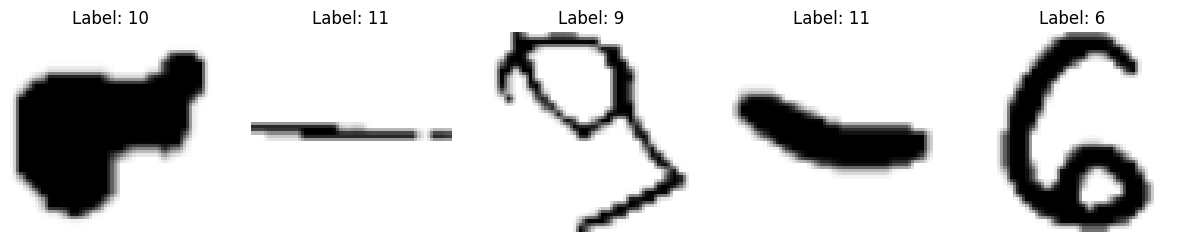

In [54]:
# Plot some samples from the dataset
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Adjust the number of subplots as needed

for i in range(5):  # Plot the first 5 samples
    idx = random.randint(0, len(dataset) - 1)  # Get a random index
    image, label = dataset[idx]
    image = np.transpose(image.numpy(), (1, 2, 0))  # Convert image tensor to numpy array and transpose dimensions
    axes[i].imshow(image.squeeze(), cmap='gray') 
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()

In [55]:
# Define the sizes of training and testing datasets
train_size = int(0.8 * len(dataset))  # 80% of the dataset for training
test_size = len(dataset) - train_size  # Remaining 20% for testing 

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [56]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [58]:
# Initialize the model
model = CNN(num_classes=14)  # Change num_classes to the number of classes in your dataset

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 16 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Step {batch_idx}/{len(train_loader)}, Loss: {loss.item()}')

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    print(f'Accuracy on test set: {100 * correct / total}%')

Epoch 0/10, Step 0/262, Loss: 2.640028953552246
Epoch 0/10, Step 16/262, Loss: 1.6400269269943237
Epoch 0/10, Step 32/262, Loss: 0.48318228125572205
Epoch 0/10, Step 48/262, Loss: 0.6548371911048889
Epoch 0/10, Step 64/262, Loss: 0.3639508783817291
Epoch 0/10, Step 80/262, Loss: 0.14992129802703857
Epoch 0/10, Step 96/262, Loss: 0.25740504264831543
Epoch 0/10, Step 112/262, Loss: 0.10075396299362183
Epoch 0/10, Step 128/262, Loss: 0.2433052808046341
Epoch 0/10, Step 144/262, Loss: 0.1703641563653946
Epoch 0/10, Step 160/262, Loss: 0.31154707074165344
Epoch 0/10, Step 176/262, Loss: 0.15843673050403595
Epoch 0/10, Step 192/262, Loss: 0.2211325764656067
Epoch 0/10, Step 208/262, Loss: 0.19671912491321564
Epoch 0/10, Step 224/262, Loss: 0.17266510426998138
Epoch 0/10, Step 240/262, Loss: 0.1857692152261734
Epoch 0/10, Step 256/262, Loss: 0.04356534034013748
Epoch 1/10, Step 0/262, Loss: 0.1602640002965927
Epoch 1/10, Step 16/262, Loss: 0.11476127803325653
Epoch 1/10, Step 32/262, Loss: 0.

In [59]:
# Save the model
torch.save(model.state_dict(), 'math_symbol_classifier.pth')

In [67]:
# Load the image
image_path = '12.jpg'
image = Image.open(image_path).convert('L')

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to match the input size expected by the model
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the image
])
image = transform(image)

# Add a batch dimension
image = image.unsqueeze(0)

# Set the model to evaluation mode
model.eval()

# Forward pass through the model
with torch.no_grad():
    output = model(image)

# Get predicted label
_, predicted = torch.max(output, 1)

# Convert predicted label tensor to integer
predicted_label = predicted.item()

# Map the predicted label to the corresponding class
predicted_class = LABEL_MAP[predicted_label]

# print("Predicted Class:", predicted_class)

11
